In [1]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

## Generate Periodic Signal

#### 1. Generate with specified latent dynamic model (nonlinear everywhere)

In [2]:
# Nonlinear functions (Input can be arrays)
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def sq(x):
    return x ** 2


def sqrtplus(x):
    sgn = np.sign(x)
    y = np.multiply(sgn, np.sqrt(np.absolute(x)))
    return y


def const_zero(x):
    return np.zeros(len(x))

def twosin2_point1(x):
    return 2 * np.sin(2*x) - 0.1

In [3]:
class TwoFuncSamp():
    def __init__(self, n_obs, obs_dim, fh1, fh2, fob1, fob2, coef_fh1, coef_fh2, coef_fob1, coef_fob2):
        
        self.h_dim = 2
        self.fh1 = fh1
        self.fh2 = fh2
        self.fob1 = fob1
        self.fob2 = fob2
        self.coef_fh1 = coef_fh1
        self.coef_fh2 = coef_fh2
        self.coef_fob1 = coef_fob1
        self.coef_fob2 = coef_fob2
        
        # Initial state multivariate normal with mean = 0.1 and covariance matrix = Diag(2)
        self.obs_dim = obs_dim
        self.n_obs = n_obs
        self.h_dim = 2
        self.initial_mean = np.array([0, 0.5])
        self.initial_log_diag_sq = np.log(np.array([1, 1.1]))

        
        # Dimension transformation from latent to observation
        self.emit_mat = np.random.uniform(1/2, 3/2, self.h_dim).reshape(self.h_dim, 1)
        
    
    def sample_all(self, n_timesteps, random_seed = None):
        mus = np.zeros([n_timesteps, self.h_dim])
        log_diag_sigmas = np.zeros([n_timesteps, self.h_dim])
        observations = np.zeros([n_timesteps, self.n_obs, self.obs_dim])
        
        if random_seed is not None:
            np.random.seed(random_seed)

        # Initialize hidden mean and diagonal entries of covariance matrix (with small Gaussian noise)
        mus[0, :] = self.coef_fh1 * self.fh1(self.initial_mean) + self.coef_fh2 * self.fh2(self.initial_mean) + 0.1 * np.random.normal(0, 1, self.h_dim)
        log_diag_sigmas[0, :] = self.coef_fh1 * self.fh1(self.initial_log_diag_sq) + self.coef_fh2 * self.fh2(self.initial_log_diag_sq) + 0.1 * np.random.normal(0, 1, self.h_dim)
        
        # Initialize observation (Latent is Gaussian, linear transform to modify dimension)
        for j in range(self.n_obs):
            samp_h = np.random.multivariate_normal(mus[0, :], np.diag(np.exp(log_diag_sigmas[0, :])), self.obs_dim)
            pre_samp_obs = np.dot(samp_h, self.emit_mat)
            temp = self.coef_fob1 * self.fob1(pre_samp_obs) + self.coef_fob2 * self.fob2(pre_samp_obs)
            temp = temp.flatten()
            observations[0, j, :] = temp + np.random.normal(0, 1, self.obs_dim)
        
        for i in range(1, n_timesteps):
            # Update hidden mean and diagonal entries of covariance matrix at time step i (with small Gaussian noise)
            mus[i, :] = self.coef_fh1 * self.fh1(mus[i - 1, :]) + self.coef_fh2 * self.fh2(mus[i - 1, :]) + 0.1 * np.random.normal(0, 1, self.h_dim)
            log_diag_sigmas[i, :] = self.coef_fh1 * self.fh1(log_diag_sigmas[i - 1, :]) + self.coef_fh2 * self.fh2(log_diag_sigmas[i - 1, :]) + 0.1 * np.random.normal(0, 1, self.h_dim)
            
            # Generate a series of observation vectors
            for j in range(self.n_obs):
                samp_h = np.random.multivariate_normal(mus[i, :], np.diag(np.exp(log_diag_sigmas[i, :])), self.obs_dim)
                pre_samp_obs = np.dot(samp_h, self.emit_mat)
                temp = self.coef_fob1 * self.fob1(pre_samp_obs) + self.coef_fob2 * self.fob2(pre_samp_obs)
                temp = temp.flatten()
                observations[i, j, :] = temp + np.random.normal(0, 1, self.obs_dim)
        return mus, log_diag_sigmas, observations


In [4]:
# Sampler following CS's suggestion
class PeriodicSamp():
    def __init__(self, n_obs, obs_dim, f_hidden, coef_fh):
        self.h_dim = 2
        self.obs_dim = obs_dim
        self.fh = f_hidden
        self.coef_fh = coef_fh
        
        # Initial state multivariate normal with mean = 0.1 and covariance matrix = Diag(2)
        self.n_obs = n_obs
        self.initial_state = np.random.multivariate_normal(np.zeros(self.h_dim), np.eye(self.h_dim), self.n_obs)

        # We do not focus on VAE, therefore the emission function is linear and should be easy to learn.
        self.emission_mat = np.random.uniform(0.1, 5, self.h_dim * self.obs_dim).reshape(self.obs_dim, self.h_dim)
        
    
    def sample_all(self, n_timesteps, random_seed = None):
        latents = np.zeros([n_timesteps, self.n_obs, self.h_dim])
        observations = np.zeros([n_timesteps, self.n_obs, self.obs_dim])
        
        if random_seed is not None:
            np.random.seed(random_seed)

        for i in range(self.n_obs):
          diag_h = np.random.uniform(1, 5, self.h_dim)
          diag_o = np.random.uniform(1, 5, self.obs_dim)

          # Hidden state is multivariate Gaussian plus iid Gaussian noise
          latents[0, i, :] = np.random.multivariate_normal(self.coef_fh * self.fh(self.initial_state[i]), np.diag(diag_h))
          # Initialize observation (linear transformation + Gaussian noise)
          observations[0, i, :] = np.matmul(self.emission_mat, latents[0, i, :]) + np.random.multivariate_normal(np.zeros(self.obs_dim), np.diag(diag_o))   
        
        for t in range(1, n_timesteps):
            for i in range(self.n_obs):
              diag_h = np.random.uniform(1, 5, self.h_dim)
              diag_o = np.random.uniform(1, 5, self.obs_dim)
              # Hidden state is multivariate Gaussian plus iid Gaussian noise
              latents[t, i, :] = np.random.multivariate_normal(self.coef_fh * self.fh(latents[t - 1, i, :]), np.diag(diag_h))
              # Initialize observation (linear transformation + Gaussian noise)
              observations[t, i, :] = np.matmul(self.emission_mat, latents[t, i, :]) + np.random.multivariate_normal(np.zeros(self.obs_dim), np.diag(diag_o))
        return latents, observations


In [5]:
h_dim = 2
obs_dim = 50
n_obs = 1000
n_timestep = 10

sampler2 = PeriodicSamp(n_obs, obs_dim, np.cos, 2)

In [6]:
latents, obs = sampler2.sample_all(n_timestep)

In [7]:
print(obs.shape)

(10, 1000, 50)


In [8]:
obs = np.transpose(obs, (1, 0, 2))
print(obs.shape)

(1000, 10, 50)


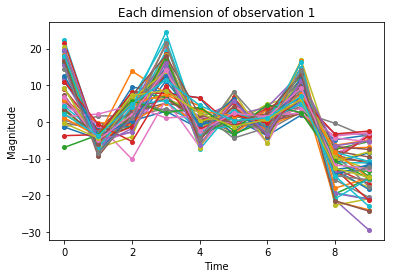

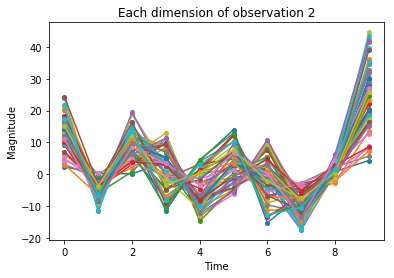

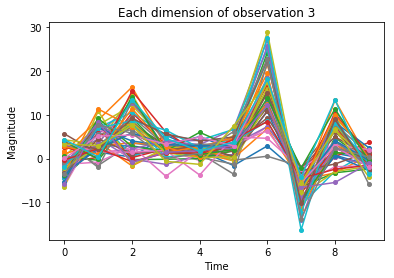

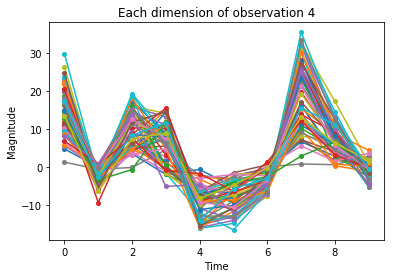

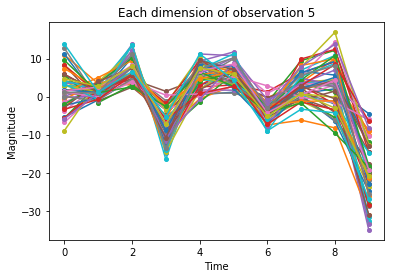

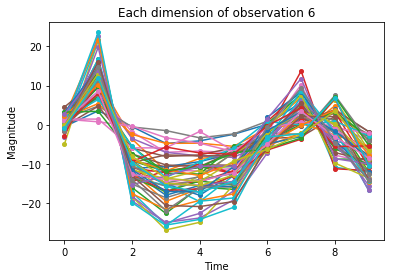

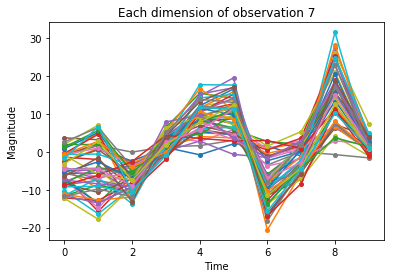

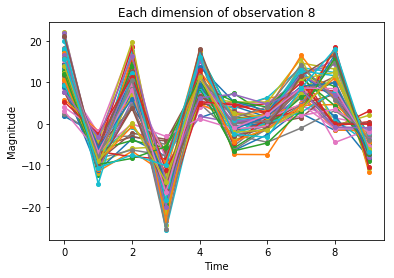

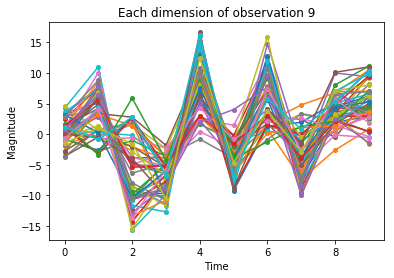

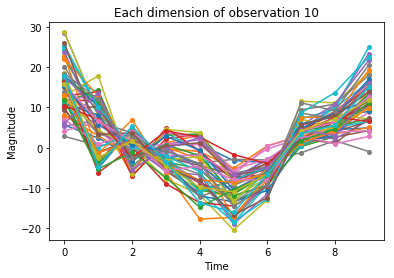

In [9]:
# Plot the temporal trend for each dimension of first five observations
x1 = np.arange(n_timestep)
for n in range(10):
    for i in range(sampler2.obs_dim):
        plt.plot(x1, obs[n, :, i], marker = 'o', markersize = 4)

    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.title('Each dimension of observation '+ str(n + 1));
    plt.show()

In [10]:
X_range = np.arange(0, 9)
Y_range = np.arange(1, 10)
X = obs[:, X_range, :]
Y = obs[:, Y_range, :]

In [11]:
print(X.shape)
print(Y.shape)

(1000, 9, 50)
(1000, 9, 50)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [13]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(800, 9, 50) (800, 9, 50) (200, 9, 50) (200, 9, 50)


In [14]:
train_X = X_train.reshape(-1, obs_dim)
test_X = X_test.reshape(-1, obs_dim)
train_Y = Y_train.reshape(-1, obs_dim)
test_Y = Y_test.reshape(-1, obs_dim)

In [15]:
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(7200, 50) (7200, 50) (1800, 50) (1800, 50)


## Prepare Dataset

In [16]:
batch_size = 8
seed = 1
epochs = 200
cuda = True
log_interval = 10
h_d = 16
l_d = 4


device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

"""

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)



test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

"""

"\n\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=True, download=True,\n                   transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n\n\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n"

#### Dataset Object

In [17]:
class SignalData():
    def __init__(self, train_obs, train_tar, test_obs, test_tar, test = False, transform = None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.obs = torch.from_numpy(train_obs).float()
          self.targets = torch.from_numpy(train_tar).float()

        else:      
          self.obs = test_obs
          self.targets = test_tar

    def __len__(self):
        return len(self.obs)
    
    def __getitem__(self, index):
        if self.transform is not None:
            ob = self.transform(self.obs[index])
            tar = self.transform(self.targets[index])
        else:
            ob = self.obs[index]
            tar = self.targets[index]
        return ob, tar

### Create Dataloader

In [18]:
train_set = SignalData(train_X, train_Y, test_X, test_Y, test = False, transform = None)
test_set = SignalData(train_X, train_Y, test_X, test_Y, test = True, transform = None)

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle = False, **kwargs)

### Model Definition

In [20]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(50, h_d)
        self.fc21 = nn.Linear(h_d, l_d)
        self.fc22 = nn.Linear(h_d, l_d)
        
        # Transition layer
        self.fct = nn.Linear(l_d, l_d)
        self.fctm = nn.Linear(l_d, l_d)
        self.fcts = nn.Linear(l_d, l_d)
        
        # Decoder should also be a probability distribution
        self.fc3 = nn.Linear(l_d, h_d)
        self.fc4 = nn.Linear(h_d, 50)
        self.fc5 = nn.Linear(h_d, 50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize1(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def transition(self, z):
        h2 = F.relu(self.fct(z))
        return self.fctm(h2), self.fcts(h2)
    
    def reparameterize2(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        return self.fc4(h3), self.fc5(h3)

    def forward(self, x):
        mu1, logvar1 = self.encode(x)
        z1 = self.reparameterize1(mu1, logvar1)
        mu2, logvar2 = self.transition(z1)
        z2 = self.reparameterize2(mu2, logvar2)
        mu_obs, logvar_obs = self.decode(z2)
        
        return mu_obs, logvar_obs, mu2, logvar2

In [21]:
model = VAE().to(device)
#adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x, mu_obs, logvar_obs, mu, logvar):
    covar = torch.diag_embed(torch.exp(logvar_obs))
    n = torch.distributions.MultivariateNormal(mu_obs, covariance_matrix = covar)
    neg_llh = torch.sum(-n.log_prob(x))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return neg_llh + KLD

### Define training and testing algorithm

In [23]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (obs, target) in enumerate(train_loader):
        obs = obs.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        mu_obs, logvar_obs, mu, logvar = model(obs.float())
        loss = loss_function(target.float(), mu_obs, logvar_obs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % log_interval == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(img), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader),
            #    loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss

In [24]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (obs, target) in enumerate(test_loader):
            obs = obs.to(device)
            target = target.to(device)
            mu_obs, logvar_obs, mu, logvar = model(obs.float())
            test_loss += loss_function(target.float(), mu_obs, logvar_obs, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

### Run Training

In [25]:
train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    


====> Epoch: 1 Average loss: 480.3242
====> Test set loss: 195.0073
====> Epoch: 2 Average loss: 188.4958
====> Test set loss: 194.4713
====> Epoch: 3 Average loss: 182.4174
====> Test set loss: 179.6350
====> Epoch: 4 Average loss: 180.8347
====> Test set loss: 179.2491
====> Epoch: 5 Average loss: 179.8917
====> Test set loss: 178.5760
====> Epoch: 6 Average loss: 179.4127
====> Test set loss: 177.9907
====> Epoch: 7 Average loss: 179.1595
====> Test set loss: 178.9273
====> Epoch: 8 Average loss: 178.6986
====> Test set loss: 177.7372
====> Epoch: 9 Average loss: 178.6925
====> Test set loss: 177.0702
====> Epoch: 10 Average loss: 178.0682
====> Test set loss: 177.0587
====> Epoch: 11 Average loss: 177.6741
====> Test set loss: 176.6274
====> Epoch: 12 Average loss: 177.4126
====> Test set loss: 176.0807
====> Epoch: 13 Average loss: 177.0394
====> Test set loss: 175.8610
====> Epoch: 14 Average loss: 176.7981
====> Test set loss: 175.7117
====> Epoch: 15 Average loss: 176.6077
====

====> Test set loss: 171.5151
====> Epoch: 120 Average loss: 168.2735
====> Test set loss: 170.2508
====> Epoch: 121 Average loss: 168.1607
====> Test set loss: 171.1529
====> Epoch: 122 Average loss: 168.0910
====> Test set loss: 171.1540
====> Epoch: 123 Average loss: 168.1933
====> Test set loss: 170.3717
====> Epoch: 124 Average loss: 168.1587
====> Test set loss: 171.1394
====> Epoch: 125 Average loss: 168.1859
====> Test set loss: 170.6264
====> Epoch: 126 Average loss: 168.2464
====> Test set loss: 170.5387
====> Epoch: 127 Average loss: 168.0051
====> Test set loss: 170.7108
====> Epoch: 128 Average loss: 167.9548
====> Test set loss: 170.8480
====> Epoch: 129 Average loss: 168.0883
====> Test set loss: 171.0634
====> Epoch: 130 Average loss: 168.0140
====> Test set loss: 171.1618
====> Epoch: 131 Average loss: 168.1411
====> Test set loss: 170.6667
====> Epoch: 132 Average loss: 168.0361
====> Test set loss: 171.3849
====> Epoch: 133 Average loss: 167.9703
====> Test set loss:

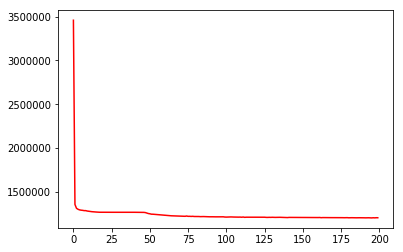

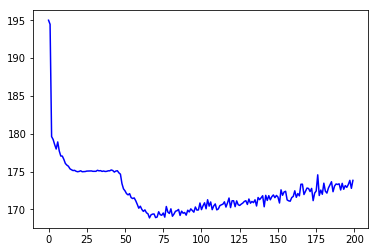

In [26]:
plt.plot(np.array(train_losses),'r')
plt.show()
plt.plot(np.array(test_losses),'b')
plt.show()

In [27]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
